<span style="font-size: 14pt">ФИВТ, АПТ, Курс по машинному обучению, Весна 2017, семинар 2 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko, </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<span style="color:black; font-size: 14pt">Plan</span>
* A few words about git
* Short Intro into Metric Algorithms
    - Margin, object types
    - Etalon vs Outlier (euclidean distance)
    - Off-line Contest: best metric, margin histogram
* Cross validation and bias-variance trade off
    - cross-validation
    - bias-variance paradigm
    - models assessment
* HW#1

<span style="color:black; font-size: 14pt">Key words</span>
   * метрические алгоритмы, kNN, weighted kNN
   * линии уровня для метрики минковского
   * метрика Джаккарда, косинусная метрика
   * проклятие размерности
   * понятие метрического отступа
   * кросс-валидация: назначение (переобучение) и различные варианты кросс-валидации

### Imports

In [17]:
from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle

import numpy as np
import pandas as pd
from matplotlib import pylab, gridspec, pyplot
from IPython.display import Image

from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.neighbors.base import _get_weights
%matplotlib inline

#  Short Intro into Metric Algorithms

## Data: Kaggle Digit Recognizer 

Link: http://www.kaggle.com/c/digit-recognizer 
Description: Classify handwritten digits using the famous MNIST data Advanced Reading: http://yann.lecun.com/exdb/mnist/index.html

In [4]:
train = pd.read_csv('../data/digit_recognizer/train.csv')

In [8]:
indices = list(range(train.shape[0]))
shuffle(indices)
subtrain = train.ix[indices[:5000]]
subtest = train.ix[indices[5000:10000]]

In [9]:
X_train = np.asarray(subtrain[list(range(1, train.shape[1]))])
Y_train = np.asarray(subtrain[[0]]).ravel()
X_test = np.asarray(subtest[list(range(1, train.shape[1]))])
Y_test = np.asarray(subtest[[0]]).ravel()

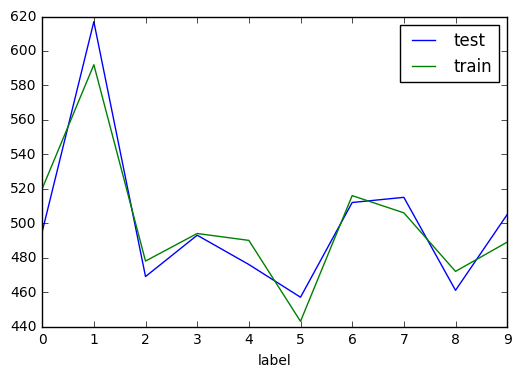

In [10]:
pd.DataFrame({
    'train' : subtrain.groupby('label')['label'].count(),
    'test' : subtest.groupby('label')['label'].count(),
}).plot()

## Metrics Algorithms
### Metrics: example

### Minkowski

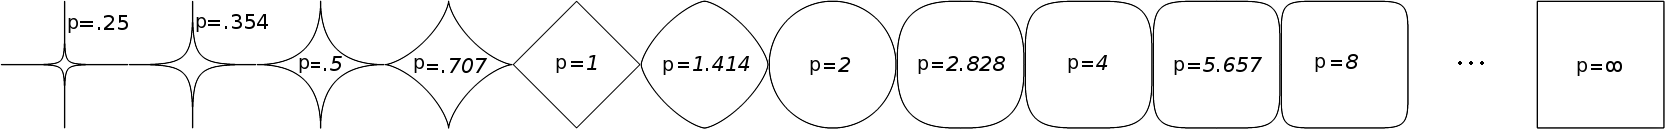

In [16]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/e/e6/Minkowski3.png', embed=True)

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


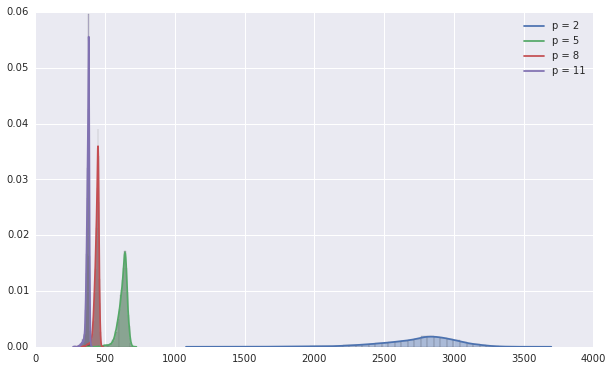

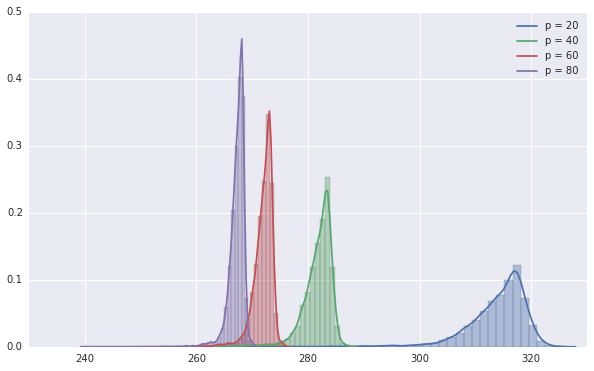

In [27]:
import seaborn as sns
from scipy.spatial.distance import cosine, euclidean, minkowski
x_exampe = X_test[10]

plt.figure(figsize=(10, 6))
for p in range(2, 12, 3):
    eucld_dists = [minkowski(x, x_exampe, p) for x in X_train]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
pylab.show()

plt.figure(figsize=(10, 6))
for p in range(20, 100, 20):
    eucld_dists = [minkowski(x, x_exampe, p) for x in X_train]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
pylab.show()

* как зависит от p величина разброса расстояний между объектами в выборке?

## Jaccard Index (метрика Джаккарда)

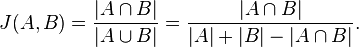

In [11]:
Image(url='https://upload.wikimedia.org/math/0/a/0/0a0633ce67c9130d890078a8d67f0474.png', embed=True)

In [12]:
Image(url='https://upload.wikimedia.org/math/a/2/8/a28e1c667f0354898727933aa746179e.png', embed=True)

## Cosine Distance

$$\text{similarity} = \cos(\theta) = {A \cdot B \over \|A\| \|B\|} = \frac{ \sum\limits_{i=1}^{n}{A_i \times B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{(A_i)^2}} \times \sqrt{\sum\limits_{i=1}^{n}{(B_i)^2}} }$$

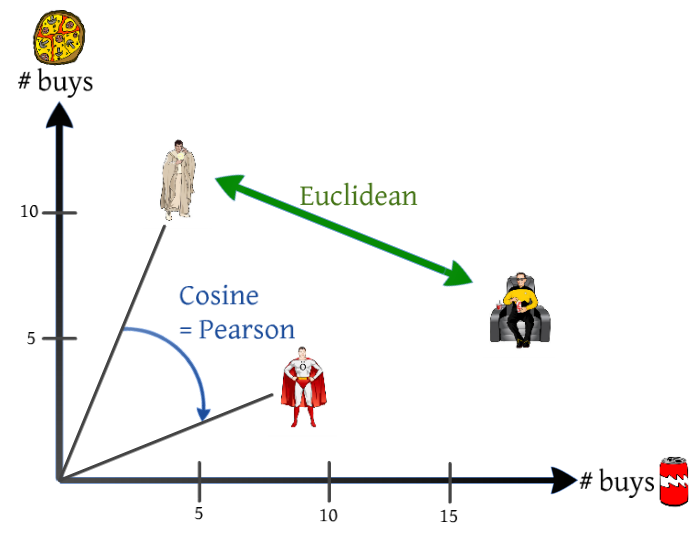

In [23]:
Image(url='https://comsysto.files.wordpress.com/2013/02/euclidean_pearson_similarity.png', embed=True)

### k Nearest Neighbors, kNN $$ a(u; X^l, k) = \arg\max\limits_{y \in Y}\sum\limits_{i= 1}^{k} [y_u^{(i)} = y] $$

Вопрос: Какие проблемы могут возникнуть при классификации нового объекта?

### k weighted Nearest Neighbors $$ a(u; X^l, k) = \arg\max\limits_{y \in Y}\sum\limits_{i= 1}^{k} [y_u^{(i)} = y] w_i $$

In [2]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold, StratifiedKFold, ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [11]:
cv_strategy = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.1, random_state=33)

In [12]:
estimators = [
    KNeighborsClassifier(),
    KNeighborsClassifier(algorithm='ball_tree'),
    KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance'),
    KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance', p=1),
    KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance', p=3),    
]
for estimator in estimators:
    scoring = cross_val_score(estimator, X_train, Y_train, scoring='accuracy')
    # print estimator.get_params()
    print('%.3lf' % scoring.mean(), '%.4lf' % scoring.std())

('0.923', '0.0043')
('0.923', '0.0043')
('0.932', '0.0046')
('0.922', '0.0045')
('0.938', '0.0051')


In [13]:
param_grid = {
    'n_neighbors' : [3,5],
    'weights' : ['distance', 'uniform'],
}
grid_cv = GridSearchCV(KNeighborsClassifier(algorithm='ball_tree'), param_grid, scoring='accuracy', cv=cv_strategy)
%time grid_cv.fit(X_train, Y_train)

Wall time: 48.8 s


GridSearchCV(cv=ShuffleSplit(5000, n_iter=5, test_size=0.1, random_state=33),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5], 'weights': ['distance', 'uniform']},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [18]:
print grid_cv.best_estimator_.get_params()
print grid_cv.best_score_
print grid_cv.best_params_
pd.DataFrame.from_records([
    [repr(params), score, scores.std()]
    for params, score, scores
    in grid_cv.grid_scores_
], columns=['kNN Parameters', 'Accuracy', 'STD']).sort('Accuracy', ascending=False)

{'n_neighbors': 3, 'algorithm': 'ball_tree', 'metric': 'minkowski', 'metric_params': None, 'p': 2, 'weights': 'distance', 'leaf_size': 30}
0.932
{'n_neighbors': 3, 'weights': 'distance'}


,kNN Parameters,Accuracy,STD
0,"{'n_neighbors': 3, 'weights': 'distance'}",0.9320,0.005367
2,"{'n_neighbors': 5, 'weights': 'distance'}",0.9308,0.007547
1,"{'n_neighbors': 3, 'weights': 'uniform'}",0.9284,0.007940
3,"{'n_neighbors': 5, 'weights': 'uniform'}",0.9244,0.009583


#### Customize metric for kNN

In [10]:
from sklearn.metrics.pairwise import distance
from sklearn.neighbors import DistanceMetric
# distance_func = DistanceMetric.get_metric('euclidean')

def my_euclidean(x, y):
    return np.sqrt(np.sum( (x - y) ** 2))

In [19]:
cv_strategy = ShuffleSplit(X_train.shape[0], n_iter=2, test_size=0.1, random_state=33) 
# estimator = KNeighborsClassifier(algorithm='brute', n_neighbors=3, metric=distance.cosine) # 0.917-0.92 (2it), 48 sec/iteration
# estimator = KNeighborsClassifier(algorithm='brute', n_neighbors=3, metric='cosine') # the same, 1.3 sec/iteration
estimator = KNeighborsClassifier(algorithm='brute', n_neighbors=3, metric=my_euclidean)
%time scoring = cross_val_score(estimator, X_train, Y_train, scoring='accuracy', cv=cv_strategy)
print scoring.mean(), scoring.std()

Wall time: 34.4 s
0.934 0.006


In [57]:
# out of the box Unsupervised Learning
estimator = NearestNeighbors()
estimator.fit(X_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_neighbors=5, p=2, radius=1.0)

#### An Outlier (example) 

In [16]:
def plot_image(image_id, X_train=X_train, size=28):
    pylab.imshow(X_train[image_id].reshape(size, size))
    
def train_set_one_out(example_id, X_train=X_train, Y_train=Y_train):
    X_minus_example = np.r_[X_train[:example_id], X_train[example_id + 1:]]
    Y_minus_example = np.r_[Y_train[:example_id], Y_train[example_id + 1:]]
    return X_minus_example, Y_minus_example

def knn_one_out(example_id, X_train=X_train, Y_train=Y_train, **kwargs):
    X, Y = train_set_one_out(example_id, X_train, Y_train)
    estimator = KNeighborsClassifier(**kwargs).fit(X, Y)
    return estimator

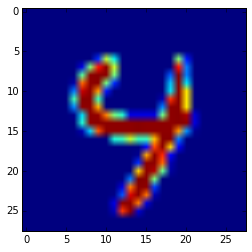

In [80]:
# Here should be example_id with neighbors from different classes!
example_id = 3807
plot_image(example_id)

In [24]:
Y_minus_example = train_set_one_out(example_id)[1]
estimator = knn_one_out(example_id)
distances, indices = estimator.kneighbors(X_train[example_id])
print distances
print indices
print Y_minus_example[indices[0]]

[[ 1867.32321787  1907.30909923  1919.92343597  1945.82990007
   1946.49736707]]
[[4572 4538 4490 2983 4246]]
[2 2 2 2 2]


In [25]:
pd.DataFrame({
    "distances": distances[0],
    "uniform_weights": 1.0,
    "indices": indices[0],
    "labels": Y_minus_example[indices[0]],
}, columns=['distances', 'indices', 'labels', 'uniform_weights'])

,distances,indices,labels,uniform_weights
0,1867.323218,4572,2,1
1,1907.309099,4538,2,1
2,1919.923436,4490,2,1
3,1945.829900,2983,2,1
4,1946.497367,4246,2,1


In [26]:
do_not_show = knn_one_out(example_id).predict_proba(X_train[example_id])
print do_not_show

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


In [27]:
pd.DataFrame({
    "distances": distances[0],
    "distance_weights": 1.0 / distances[0],
    "normalized_weights": 1.0 / distances[0] / sum(1.0 / distances[0]),
    "indices": indices[0],
    "labels": Y_minus_example[indices[0]],
}, columns=['distances', 'indices', 'labels', 'distance_weights', 'normalized_weights'])

,distances,indices,labels,distance_weights,normalized_weights
0,1867.323218,4572,2,0.000536,0.205313
1,1907.309099,4538,2,0.000524,0.201009
2,1919.923436,4490,2,0.000521,0.199688
3,1945.829900,2983,2,0.000514,0.197029
4,1946.497367,4246,2,0.000514,0.196962


In [28]:
weights = _get_weights(distances, 'distance')
show_flag = True
if show_flag:
    print weights
    print weights / weights.sum()
    print knn_one_out(example_id, weights='distance').predict_proba(X_train[example_id])

[[ 0.00053553  0.0005243   0.00052085  0.00051392  0.00051374]]
[[ 0.20531279  0.2010085   0.19968783  0.19702922  0.19696166]]
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


In [29]:
denominator = sum(1.0 / (1.0 + np.arange(5)))
pd.DataFrame({
    "distances": 1.0 / (1.0 + np.arange(5)),
    "w_distances": 1.0 / (1.0 + np.arange(5)) / denominator,
    "indices": indices[0],
    "labels": Y_minus_example[indices[0]],
}, columns=['distances', 'indices', 'labels', 'w_distances'])

,distances,indices,labels,w_distances
0,1.000000,4572,2,0.437956
1,0.500000,4538,2,0.218978
2,0.333333,4490,2,0.145985
3,0.250000,2983,2,0.109489
4,0.200000,4246,2,0.087591


#### Most Similar Items

In [19]:
estimator = NearestNeighbors()
estimator.fit(X_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

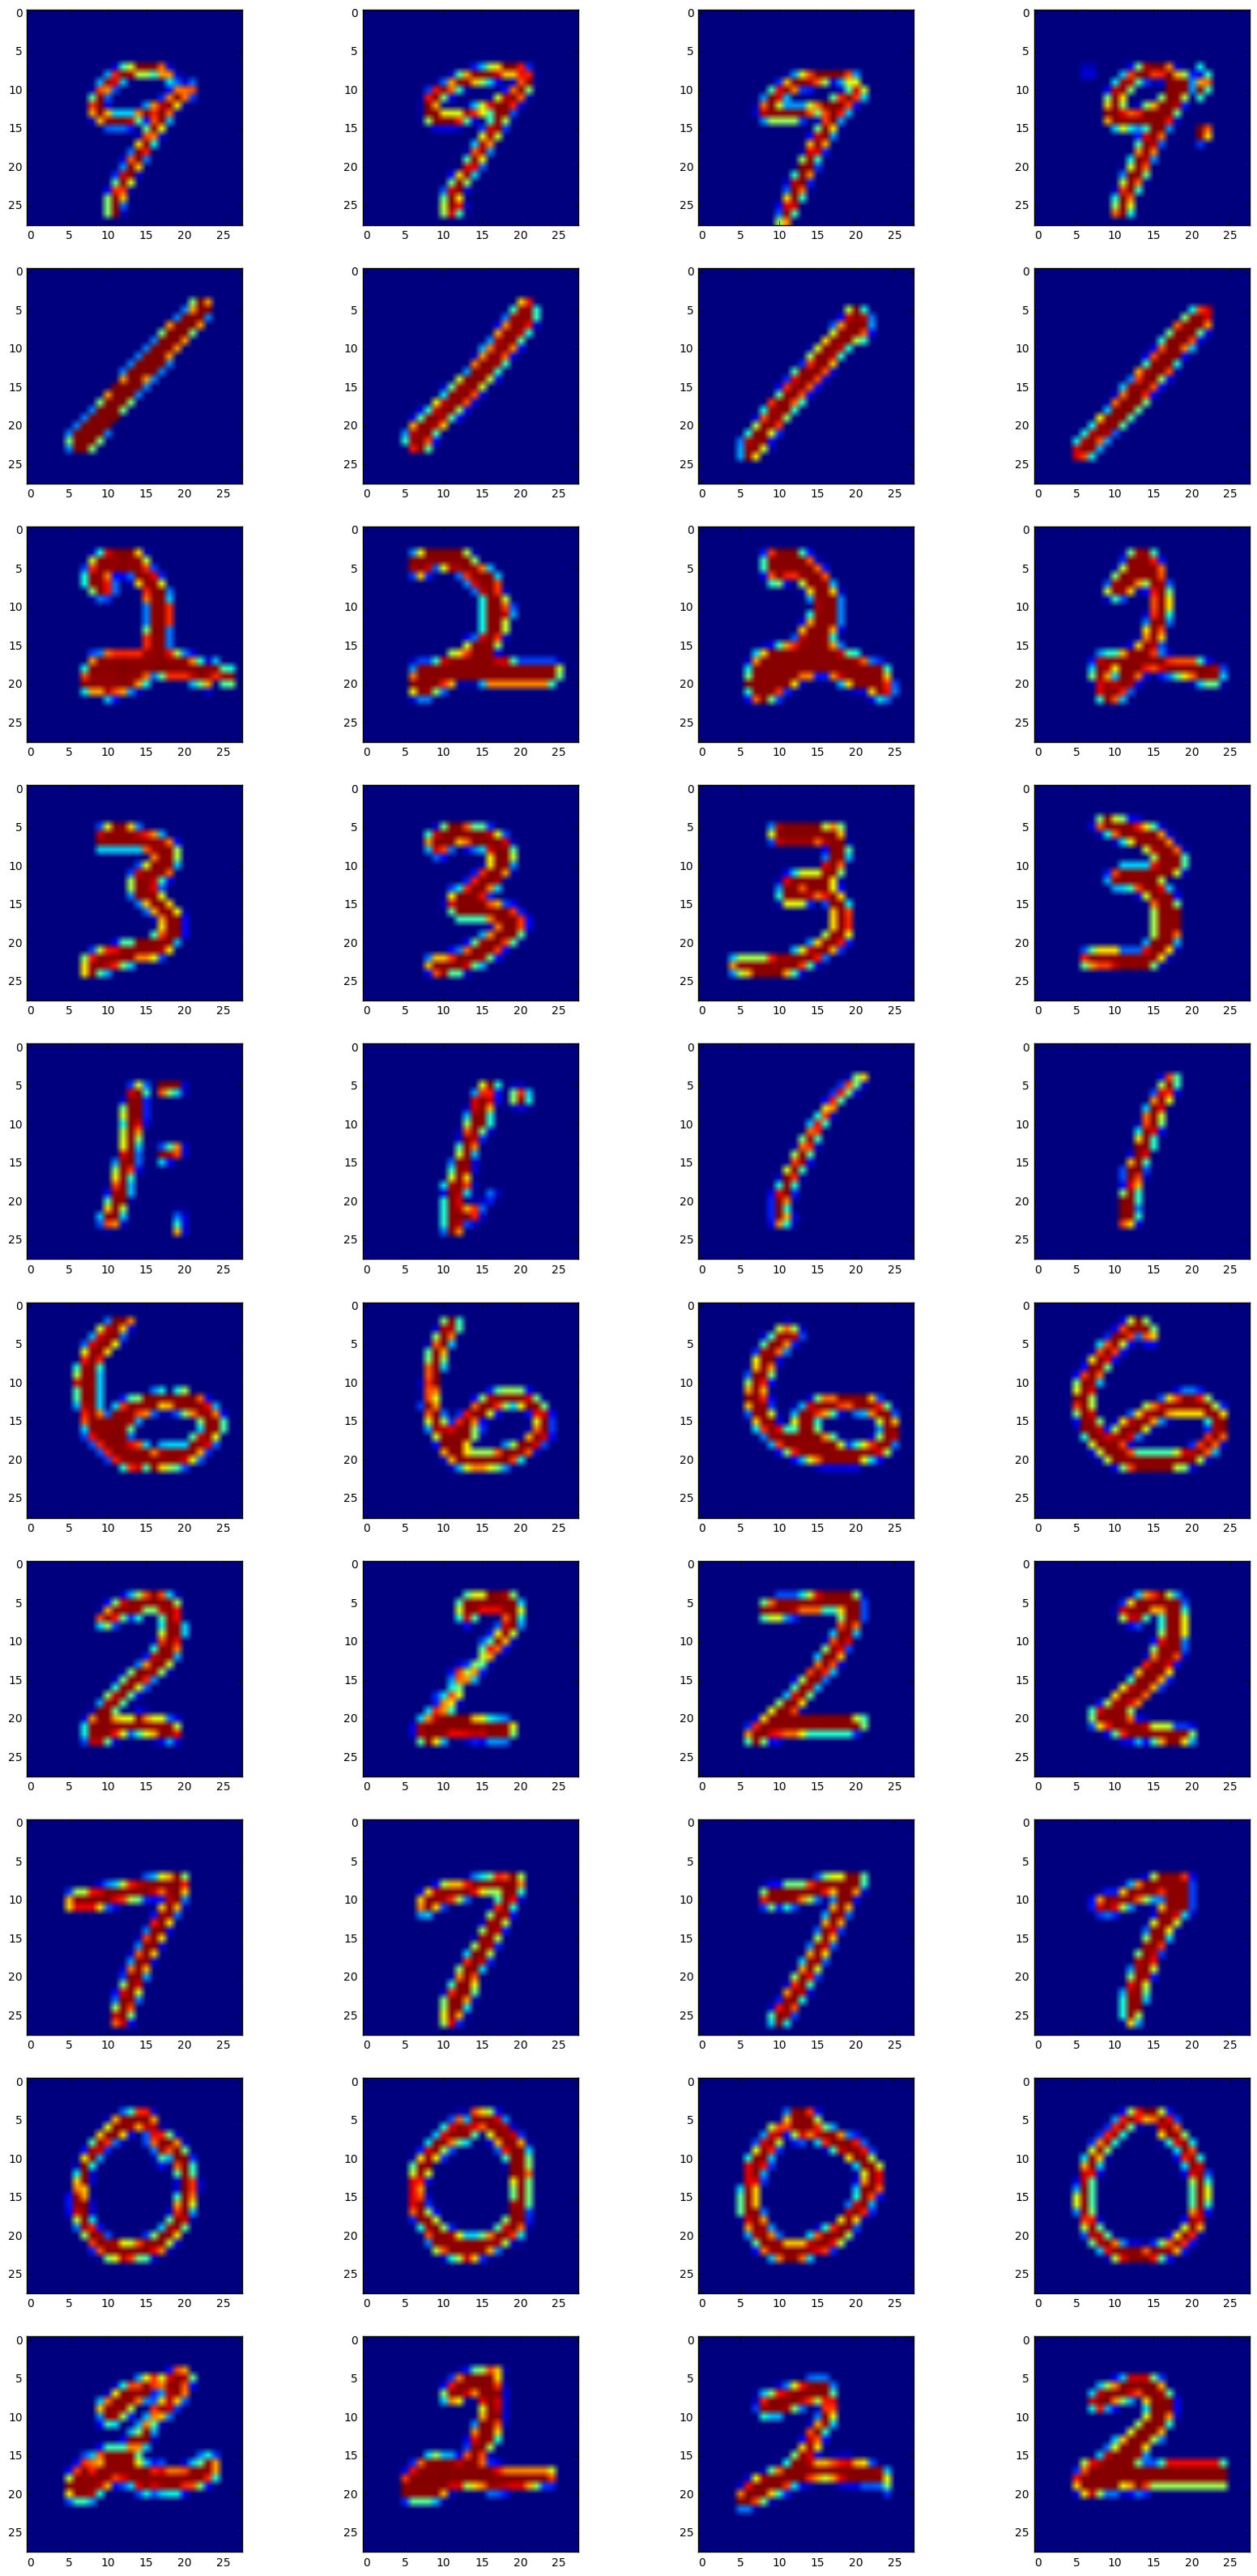

In [23]:
example_ids = [
    3023, 323, 945, 3807, 1415,
    2664, 647, 3453, 1856, 2285
]
fig = pyplot.gcf()
fig.set_size_inches(20.5,40.5)
for pylab_index, example_id in enumerate(example_ids):
    pylab.subplot(len(example_ids), 4, pylab_index * 4 + 1)
    pylab.imshow(X_train[example_id,:].reshape(28,28)) #, cmap='hot'
    distances, indices = estimator.kneighbors([X_train[example_id]])
    indices = indices[0]
    for neighbor_index, neighbor in enumerate(X_train[indices[1:4]]):
        pylab.subplot(len(example_ids), 4, pylab_index * 4 + 1 + neighbor_index + 1)
        pylab.imshow(neighbor.reshape(28,28))

### Margin  $$ a(u) = \arg\max\limits_{y \in Y}\Gamma_{y}(u) $$ $$ M(x_i) = \Gamma_{y_i}(x_i) -\max\limits_{y \in Y\y_i} \Gamma_{y_i}(x_i) $$

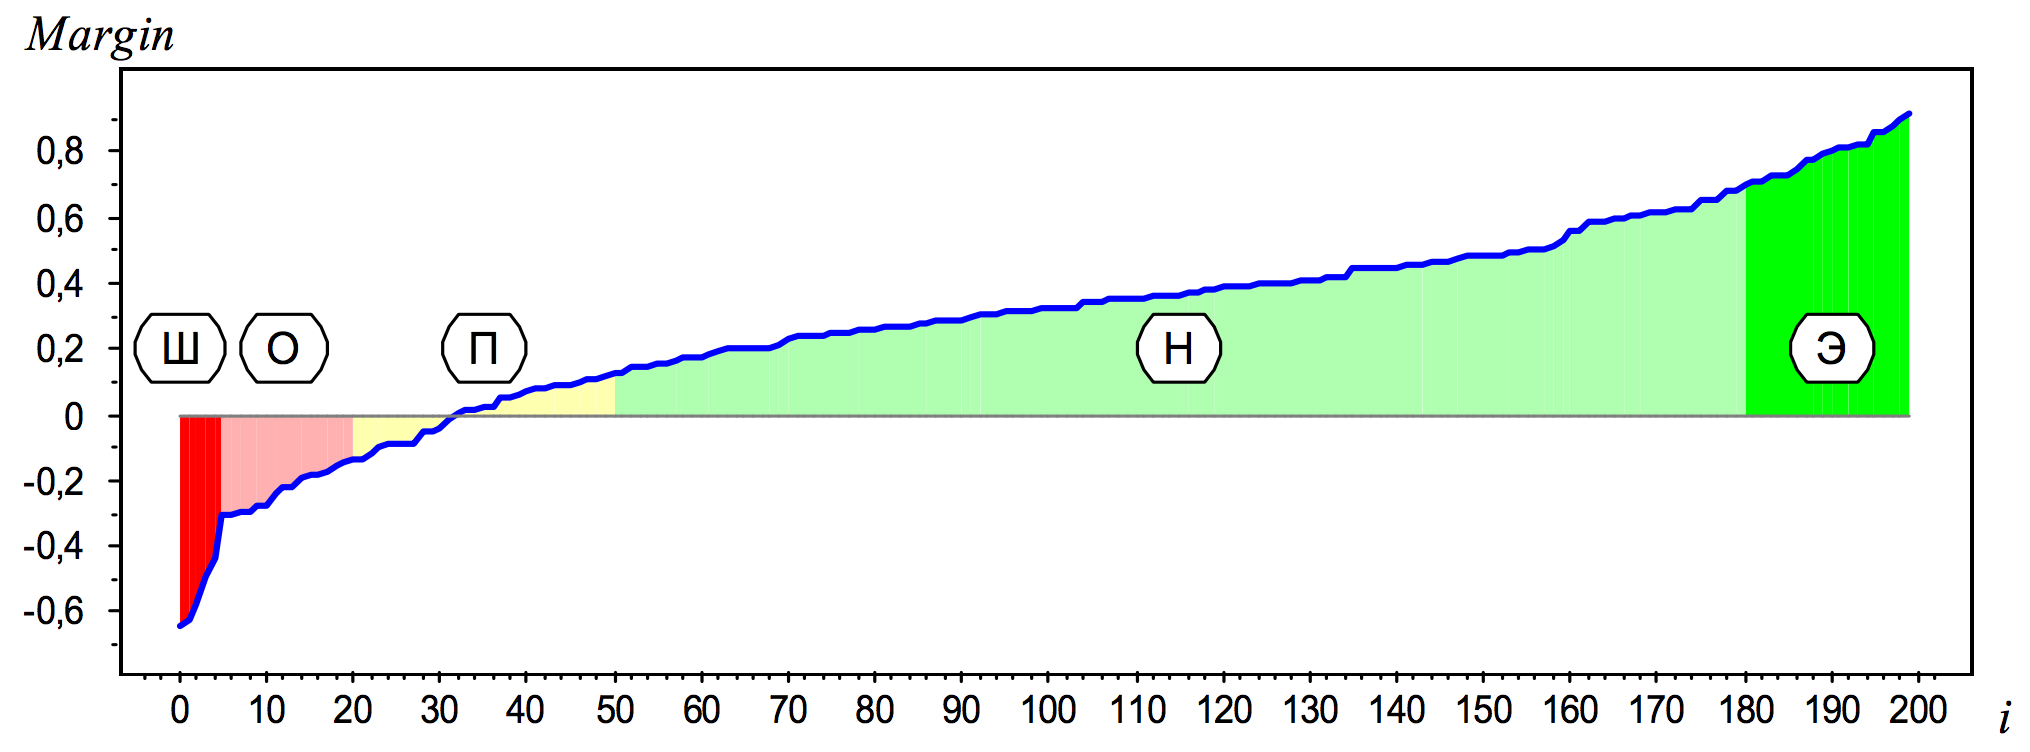

In [22]:
Image('pic/Margin.png', height=300)

In [26]:
def calculate_margin(estimator, class_id, example, Y_train=Y_train, debug=False):
    """
    We assume that we have uniform weights. We also assume
    that we fit our estimator on the whole set. It means
    that we already have our example inside estimator. That is
    why, the first nearest neighbor would be example object.
    
    @param estimator: KNeighborsMixin sublcassed object
        should be already fitted.
    @param class_id: example object has class class_id
    @param example: numpy.array feature represenation of
        example (1x784 matrix based on 28x28 reshaping)
    @param Y_train: we should know object class by its index id
    @params debug: do we need to print debug information?
    """
    counts = Counter(Y_train[estimator.kneighbors([example])[1][0][1:]])
    if debug:
        # in production environment we should use logging module!
        print(counts)
    margin = counts[class_id]
    del counts[class_id]
    if counts:
        margin -= max(counts.values())
    margin *= 1.0 / (estimator.n_neighbors - 1)
    return margin

In [27]:
def collect_margins(n_neighbors, margin_calculator, X_train=X_train, Y_train=Y_train, debug_example_id = None, **kwargs):
    margins = []
    estimator = NearestNeighbors(n_neighbors=n_neighbors + 1, **kwargs)
    estimator.fit(X_train)
    for example_id, (class_id, example) in enumerate(zip(Y_train, X_train)):
        margin = margin_calculator(estimator, class_id, example, debug=(example_id == debug_example_id))
        margins.append(margin)

    if debug_example_id is not None:
        print(margins[debug_example_id])
    return margins

In [28]:
margins = collect_margins(n_neighbors=5, margin_calculator=calculate_margin, debug_example_id=3807)

Counter({3: 5})
1.0


('accuracy:', 0.928)
(-1.0, 40)
(-0.8, 16)
(-0.6000000000000001, 74)
(-0.4, 37)
(-0.2, 117)
(0.0, 76)
(0.2, 187)
(0.4, 96)
(0.6000000000000001, 528)
(1.0, 3829)


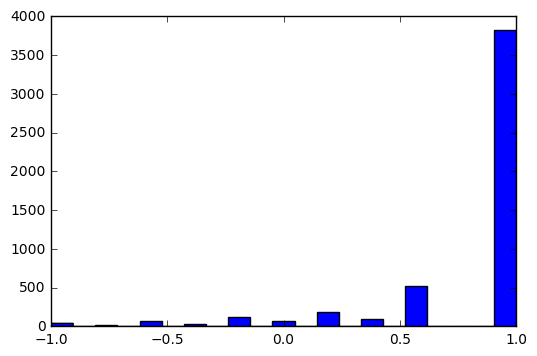

In [29]:
print('accuracy:', 1.0 * sum(1 for margin in margins if margin > 0.0) / len(margins))
pylab.hist(margins, bins=21)
counts = Counter(margins)
for margin in sorted(counts.keys()):
    print (margin, counts[margin])

(-1.0, 1.0)


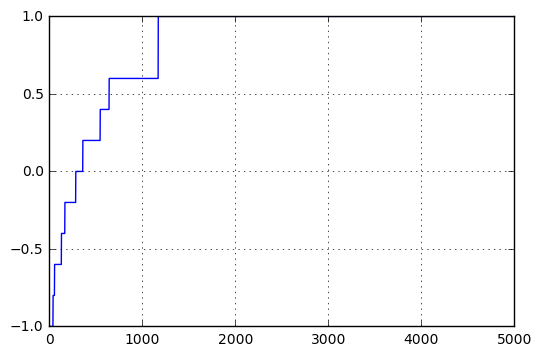

In [30]:
pylab.plot(range(len(margins)), sorted(margins))
pylab.grid()
print (min(margins), max(margins))

### Outlier vs Etalon

In [31]:
def plot_extremes(margins, to_plot_count=4, Y_train=Y_train):
    sorted_margins = sorted((margin, object_id) for object_id, margin in enumerate(margins))
    example_ids = (list(map(itemgetter(0), sorted_margins[:to_plot_count])) + list(map(itemgetter(0), sorted_margins[-to_plot_count:])))
    # output object ids
    # print example_ids
    # output object margins
#     print (list(map(itemgetter(0), sorted_margins[:to_plot_count])) + list(map(itemgetter(0), sorted_margins[-to_plot_count:])))
    # output object lables
    print (Y_train[example_ids][:to_plot_count])
    print (Y_train[example_ids][to_plot_count:])
    fig = pyplot.gcf()
    fig.set_size_inches(17.5,10.5)
    for pylab_index, example_id in enumerate(example_ids):
        pylab.subplot(2, to_plot_count, pylab_index + 1)
        plot_image(example_id)

C:\Users\rusrom\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
C:\Users\rusrom\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
C:\Users\rusrom\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


[7 7 7 7]
[2 2 2 2]


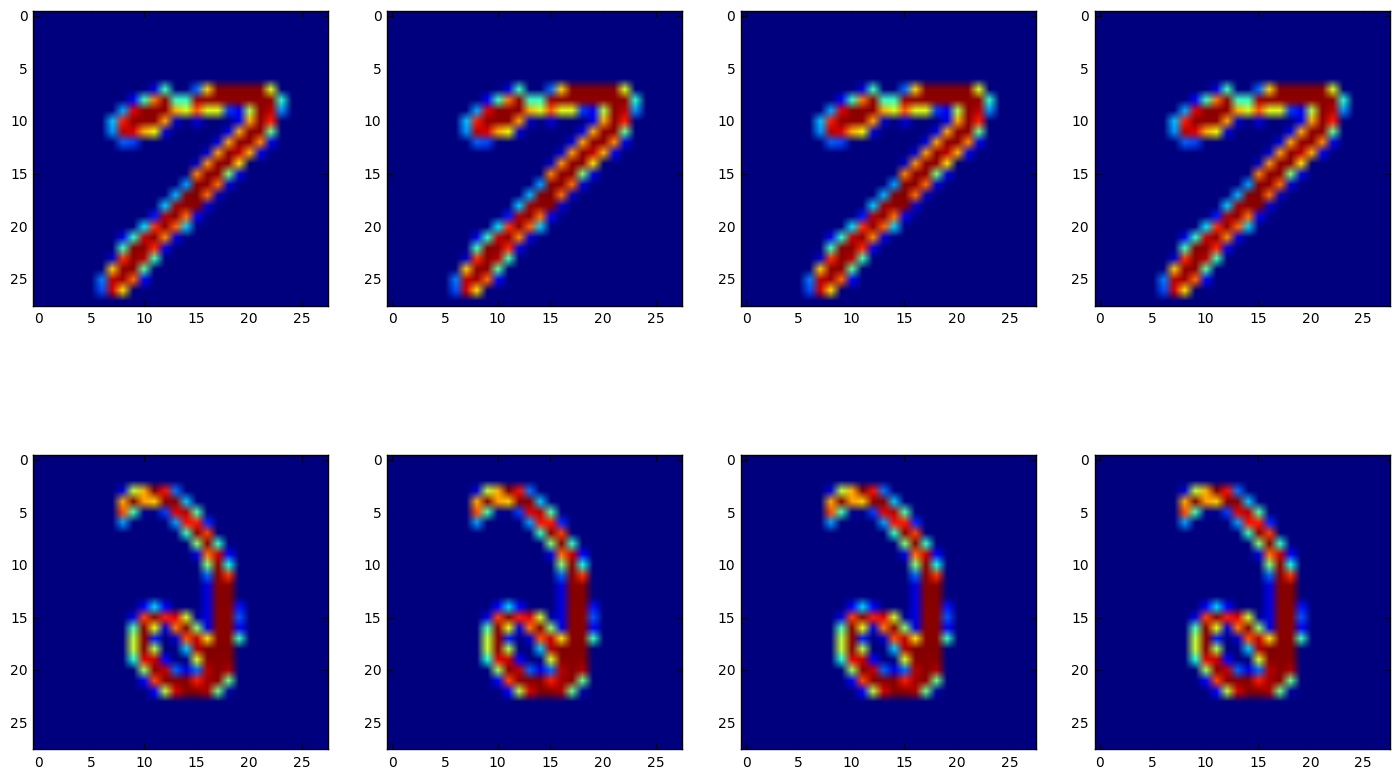

In [32]:
plot_extremes(margins, to_plot_count=4)

#### Repeat for the weighted metric

In [37]:
def calculate_weighted_margin(estimator, class_id, example, Y_train=Y_train, debug=False):
    """
    We assume that we have distance weights. We also assume
    that we fit our estimator on the whole set. It means
    that we already have our example inside estimator. That is
    why, the first nearest neighbor would be example object.
    
    @param estimator: KNeighborsMixin sublcassed object
        should be already fitted.
    @param class_id: example object has class class_id
    @param example: numpy.array feature represenation of
        example (1x784 matrix based on 28x28 reshaping)
    @param Y_train: we should know object class by its index id
   
    """
    distances, indices = estimator.kneighbors([example])
    weights = _get_weights(np.asarray([distances[0][1:]]), 'distance')[0]
    if weights.sum()>0:
        weights /= weights.sum()     # деление на ноль
    classes = Y_train[indices[0][1:]]
    
    counts = Counter()
    for class_id_, weight in zip(classes, weights):
        counts[class_id_] += weight
    if debug:
        # in production environment we should use logging module!
        print (counts)
    margin = counts[class_id]
    del counts[class_id]
    if counts:
        margin -= max(counts.values())
    return margin

In [74]:
# est = NearestNeighbors(n_neighbors=5 + 1)
# est.fit(X_train)
# distances, indices = est.kneighbors(X_train[3807])
# weights = _get_weights(np.asarray([distances[0][1:]]), 'distance')[0]
# weights /= weights.sum()
calculate_weighted_margin(estimator = est, class_id=4, example=X_train[3807], Y_train=Y_train, debug=True)

Counter({4: 0.80290485645454235, 9: 0.19709514354545757})


0.60580971290908481

In [75]:
margins = collect_margins(n_neighbors=5, margin_calculator=calculate_weighted_margin, debug_example_id=3807)

Counter({4: 0.80290485645454235, 9: 0.19709514354545757})
0.605809712909


accuracy: 0.9328


(array([  4.90000000e+01,   0.00000000e+00,   1.70000000e+01,
          1.00000000e+00,   7.90000000e+01,   0.00000000e+00,
          4.60000000e+01,   1.00000000e+00,   1.17000000e+02,
          9.00000000e+00,   6.10000000e+01,   6.00000000e+00,
          1.58000000e+02,   3.60000000e+01,   8.80000000e+01,
          1.80000000e+01,   3.53000000e+02,   1.92000000e+02,
          0.00000000e+00,   0.00000000e+00,   3.76900000e+03]),
 array([-1.        , -0.9047619 , -0.80952381, -0.71428571, -0.61904762,
        -0.52380952, -0.42857143, -0.33333333, -0.23809524, -0.14285714,
        -0.04761905,  0.04761905,  0.14285714,  0.23809524,  0.33333333,
         0.42857143,  0.52380952,  0.61904762,  0.71428571,  0.80952381,
         0.9047619 ,  1.        ]),
 <a list of 21 Patch objects>)

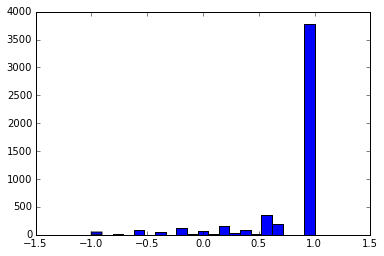

In [76]:
print ('accuracy:', 1.0 * sum(1 for margin in margins if margin > 0.0) / len(margins))
pylab.hist(margins, bins=21)

-1.0 1.0


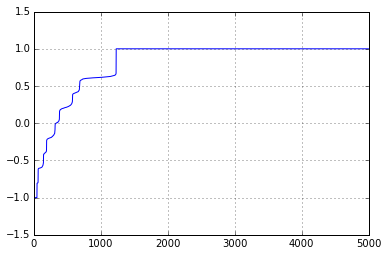

In [77]:
pylab.plot(range(len(margins)), sorted(margins))
pylab.grid()
print (min(margins), max(margins))

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


[5 5 5 5]
[7 7 7 7]


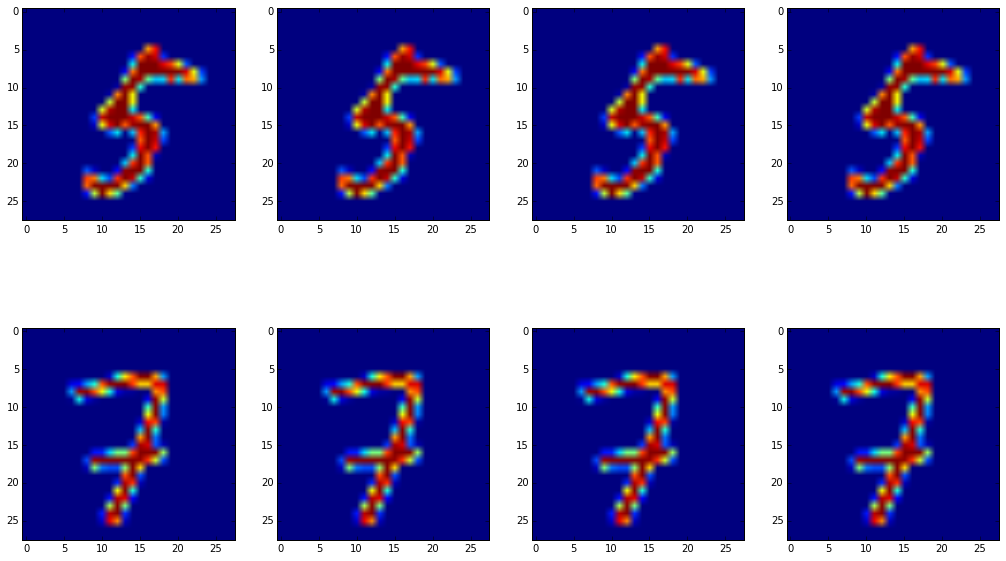

In [84]:
plot_extremes(margins, to_plot_count=4)

### Off-line contest (HW)

In [53]:
def metric_example(x, y):
    return np.sqrt(np.sqrt(np.sum( (x - y) ** 4)))

def my_metric_mink(x, y):
    return (np.sum( abs(x - y) ** 3.5))**(1/3.5)

def metric_cos(x, y):
    return 1 - np.dot(x,y)/(np.sqrt(np.dot(x,x)*np.dot(y,y)))

#from scipy.spatial.distance import mahalanobis

#def metric_mahalanobis(x, y):
#    return mahalanobis(x, y, np.linalg.norm(x - y)) 

In [117]:
metric_mink(X_train[0], X_train[1])
# print(np.sum( (X_train[0] - X_train[1])**4))
# import math
# np.sum(math.pow((X_train[0] - X_train[1])),4)

125578885228.83086

In [114]:
np.sum(abs(X_train[0] - X_train[1])**3.5)

18450750532.317303

In [38]:
# Takes a lot of time!
%time margins = collect_margins(n_neighbors=5, margin_calculator=calculate_weighted_margin, debug_example_id=3807, metric=metric_example)

Counter({3: 0.99999999999999989})
1.0
Wall time: 17min 5s


In [39]:
print ('accuracy:', 1.0 * sum(1 for margin in margins if margin > 0.0) / len(margins))

('accuracy:', 0.9436)


#### Insert Your Metric

In [54]:
metric_properties = {
#    'euc' : {'metric' : 'euclidean'}, # 1
#     'cheb' : {'metric' : 'chebyshev'}, # 
#     'cosine' : {'metric' : metric_cos}, # 
    'mink3.5' : {'metric' : my_metric_mink}, # 2
#    'mink3' : {'p' : 3},  # 3
#     'mink4' : {'metric': metric_example}, #
}

In [49]:
# metric_margins = {}
for name, metric in metric_properties.items():
    print('processing team %s...' % name)
    %time margins = collect_margins(n_neighbors=5, margin_calculator=calculate_weighted_margin, **metric)
    metric_margins[name] = sorted(margins)

processing team cosine...
Wall time: 2min 32s
processing team mink3.5...
Wall time: 15min 48s


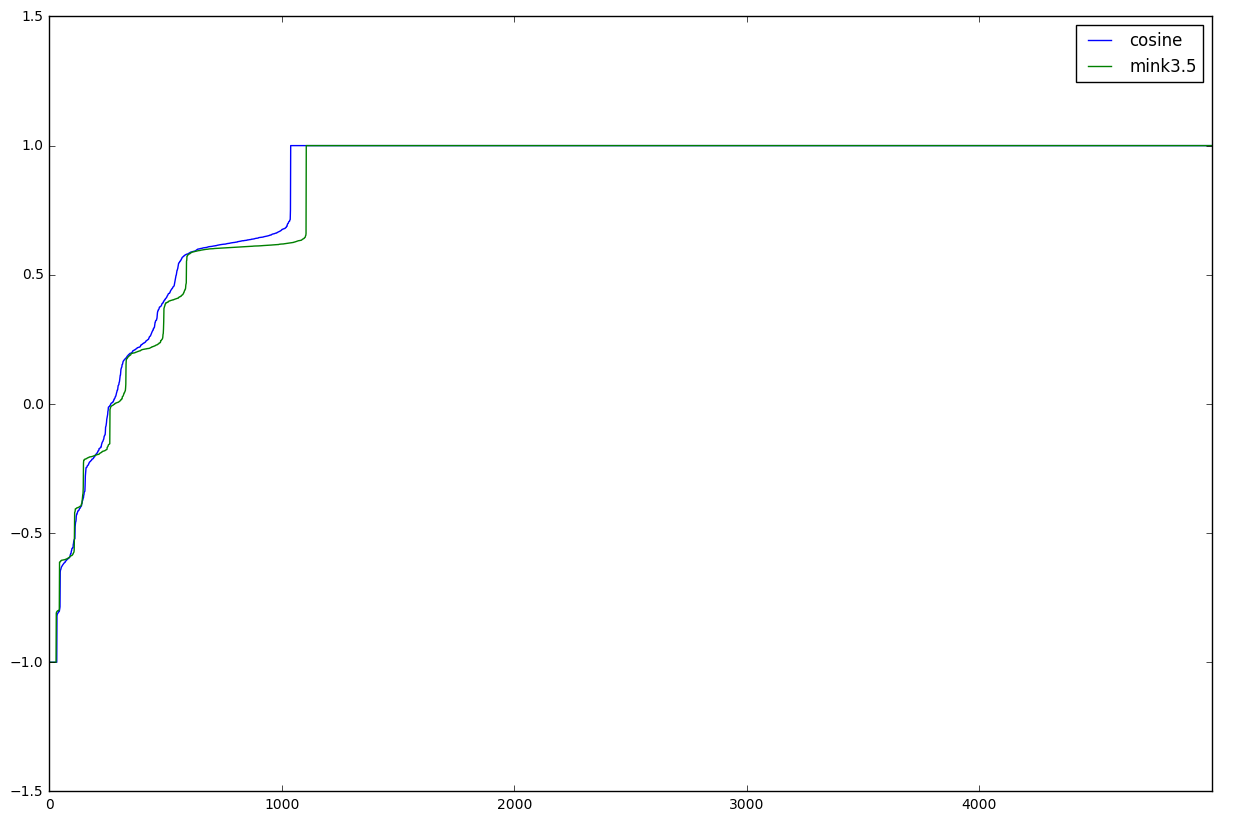

In [51]:
team_df = pd.DataFrame(metric_margins)
team_df.plot(figsize = (15, 10))

In [128]:
pd.DataFrame({
    'accuracy' : team_df.apply(lambda margins: 1.0 * sum(1 for margin in margins if margin > 0.0) / len(margins))
}).sort('accuracy', ascending=False)

,accuracy
cosine,0.9476
euc,0.9328
mink0.25,0.8666


## Cross-validation

* intro into cross-validation and bias-variance trade-off
    - sklearn-cross-validation
    - seminar2.pdf
* model assessment
    - reading_data.ipnb
    

# Summary

* Metrics Algorithms
    - the simplest ML algorithms 
    - score depends on the metric and space property.
    - use all data set to classify, need $O(log(n))$ to predict. 
    - there are эталонные, неинформативные, пограничные, ошибки и выбросы
* Cross_validation
    - way to fit ML algorithms

* HW:
    - learn datasets and data in sklearn (see sklearn-datasets.ipnb)
    - learn knn: sklearn-knn-surfaces.ipynb